In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats

In [2]:
data_path = '../../data/lda_jsd_toprev_conlen/'

In [3]:
fandom_list = [i for i in os.listdir(data_path) if 'tsv' in i]

In [4]:
fandom_list

['shakespare_william_works_temporal_lda_jsd_toprev_full.tsv',
 'buffy_the_vampire_slayer_temporal_lda_jsd_toprev_full.tsv',
 'les_miserables_all_media_types_temporal_lda_jsd_toprev_full.tsv',
 'one_direction_temporal_lda_jsd_toprev_full.tsv',
 'ms_paint_adventures_temporal_lda_jsd_toprev_full.tsv',
 'marvel_temporal_lda_jsd_toprev_full.tsv',
 'kuroko_no_basuke_temporal_lda_jsd_toprev_full.tsv',
 'tolkien_j_r_r_works_&_related_fandoms_temporal_lda_jsd_toprev_full.tsv',
 'harry_potter_temporal_lda_jsd_toprev_full.tsv',
 'haikyuu_temporal_lda_jsd_toprev_full.tsv',
 'dcu_temporal_lda_jsd_toprev_full.tsv',
 'bishoujo_senshi_sailor_moon_temporal_lda_jsd_toprev_full.tsv',
 'the_walking_dead_&_related_fandoms_temporal_lda_jsd_toprev_full.tsv',
 'supernatural_temporal_lda_jsd_toprev_full.tsv',
 'doctor_who_&_related_fandoms_temporal_lda_jsd_toprev_full.tsv',
 'homestuck_temporal_lda_jsd_toprev_full.tsv',
 'arthurian_mythology_&_related_fandoms_temporal_lda_jsd_toprev_full.tsv',
 'attack_on_tita

In [5]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

## Aggregate

In [20]:
def create_normed_dfs(df):
    
    # Normalize effects of authors by turning kudos into z-score corresponding to works from this author
    # Seems not useful b/c many authors only have 1 work
#     author_list = df.Author.drop_duplicates().tolist()
#     combined = []
#     for author in author_list:
#         df_a = df[df.Author == author]
#         if len(df_a) > 1:
#             df_a['Kudos'] = (df_a['Kudos'] - df_a['Kudos'].mean())/df_a['Kudos'].std(ddof=0)
#             combined.append(df_a)        
#     df = pd.concat(combined)
#     df = df[df.Kudos != 0]

# #     Normalize by creating hits/kudos 
#     df = df[df.Hits != 0]
#     df = df[df.Kudos != 0]
#     df['Kudos/Hits'] = df['Kudos'].astype(float)/df['Hits'].astype(float)
    
#     Normalize by log scale
#     df = df[df.Kudos != 0]
#     df['Kudos'] = np.log(df['Kudos'])
#     df = df[df.Hits != 0]
#     df['Hits'] = np.log(df['Hits'])
#     df['Kudos/Hits'] = df['Kudos'] - df['Hits']

#     # filter 0s
# #     df = df.fillna(0)"

#     # turn into z scores
    df['Bookmarks'] = df['Bookmarks']/df['Chapters']
    df = df.dropna(subset=['Bookmarks'])
    df = df[np.isfinite(df['Bookmarks'])]
    df['Bookmarks'] = (df['Bookmarks'] - df['Bookmarks'].mean())/df['Bookmarks'].std(ddof=0)
    
#     df = df.dropna(subset=['Comments'])
#     df = df[np.isfinite(df['Comments'])]
#     df['Comments'] = (df['Comments'] - df['Comments'].mean())/df['Comments'].std(ddof=0)

    return df

In [21]:
def create_dict(df, field, binsize):
    
    # Make bins
    df.JSD = df.JSD.astype(float)
    min_jsd = min(df.JSD.tolist())
    max_jsd = max(df.JSD.tolist())
    dic = {}
    for i in np.arange(min_jsd, max_jsd, binsize):
        df_s = df[(df.JSD >= i) & (df.JSD < i+binsize)]
#         if len(df_s) > 9:
#             print (min_cos, max_cos)
#             print(df_s[field].tolist())
        li = df_s[field].tolist()
        if len(li) > 0:
            dic[i] = bootstrap_resample(li)
    return dic

In [22]:
def plot_agg(flist, title):
    df_all = []
    for i,fandom in enumerate(flist):
        df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t')
        df = create_normed_dfs(df)
        df = df[['JSD', 'Bookmarks']].dropna()
        df_all.append(df)
#         print(fandom, '   ', len(df))
    df = pd.concat(df_all)
    df = df.sort_values(by = 'JSD')[5:-5]
    df = df.sort_values(by = 'Bookmarks')[5:-5]

    dic = create_dict(df, 'Bookmarks', 0.05)
    x = sorted(dic.keys())
    y = [dic[j][0] for j in x]

    #     Make error bars
    lower_error = [dic[j][0]-dic[j][1] for j in x]
    upper_error = [dic[j][2]-dic[j][0] for j in x]
    asymmetric_error = [lower_error, upper_error]

    print(dic)

    plt.errorbar(x, y, yerr=asymmetric_error,fmt='o')
    plt.scatter(x, y)
    plt.xlabel('Novelty',fontsize=15)
    plt.ylabel('Bookmarks (z-score)',fontsize=15)

    plt.errorbar(x, y, yerr=asymmetric_error,fmt='o')
    plt.scatter(x, y)
    plt.title(title)
    

{0.3183411357554178: (0.29233516568034834, 0.024238078285889583, 0.617133573448504), 0.36834113575541777: (0.2871806661664359, 0.21008469302514796, 0.37104403487104076), 0.41834113575541776: (0.17699276742209707, 0.15518255359572267, 0.19965909287131772), 0.46834113575541775: (0.11789009689218069, 0.1080408608503596, 0.12777511799579122), 0.5183411357554177: (0.058592390698911964, 0.052530374342019015, 0.06505624733416811), 0.5683411357554178: (-0.011680729350875715, -0.015460974072291725, -0.007845392013090464), 0.6183411357554177: (-0.044977810722696986, -0.04826990918771911, -0.041521476033411116), 0.6683411357554176: (0.025720876302607262, -0.0023433014211147432, 0.05321990647970966)}


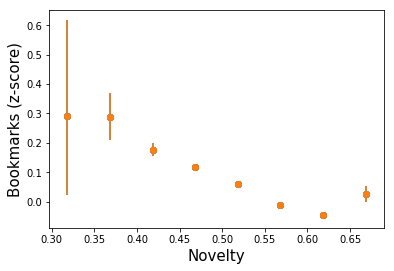

In [23]:
plot_agg(fandom_list, '')